# Comparing Support Vector Machines, Decision Trees and Naive Bayes for Heart Failure Prediction

Notebook for workshop assignment [Workshop: Compare Support Vector Machines to DTs and NB](https://hiof.instructure.com/courses/8923/assignments/41776?module_item_id=283971)

In [141]:
# Notebook for Workshop: Compare Support Vector Machines, DTs and NB
# https://hiof.instructure.com/courses/8923/assignments/41776?module_item_id=283971

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.base import BaseEstimator, ClassifierMixin 
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, get_scorer
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [142]:
pd.set_option("display.max_columns", None)

I've added some markdown cells that provide some tips into how to discuss results. Note that my comments were made to a
particular run. Due the limitations with setup related to random sampling, we get different results each time we run. The discussions might therefore be slightly errornous when discussion concrete numbers, but they still provide valuable tips for how to discuss results.

In [143]:
# Load the dataset and show first 5 rows

dataset = pd.read_csv('../data/heart_failure/heart_failure_clinical_records_dataset.csv')
dataset.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


## Exploratory Analysis and Processing

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'anaemia'}>,
        <Axes: title={'center': 'creatinine_phosphokinase'}>,
        <Axes: title={'center': 'diabetes'}>],
       [<Axes: title={'center': 'ejection_fraction'}>,
        <Axes: title={'center': 'high_blood_pressure'}>,
        <Axes: title={'center': 'platelets'}>,
        <Axes: title={'center': 'serum_creatinine'}>],
       [<Axes: title={'center': 'serum_sodium'}>,
        <Axes: title={'center': 'sex'}>,
        <Axes: title={'center': 'smoking'}>,
        <Axes: title={'center': 'time'}>],
       [<Axes: title={'center': 'DEATH_EVENT'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

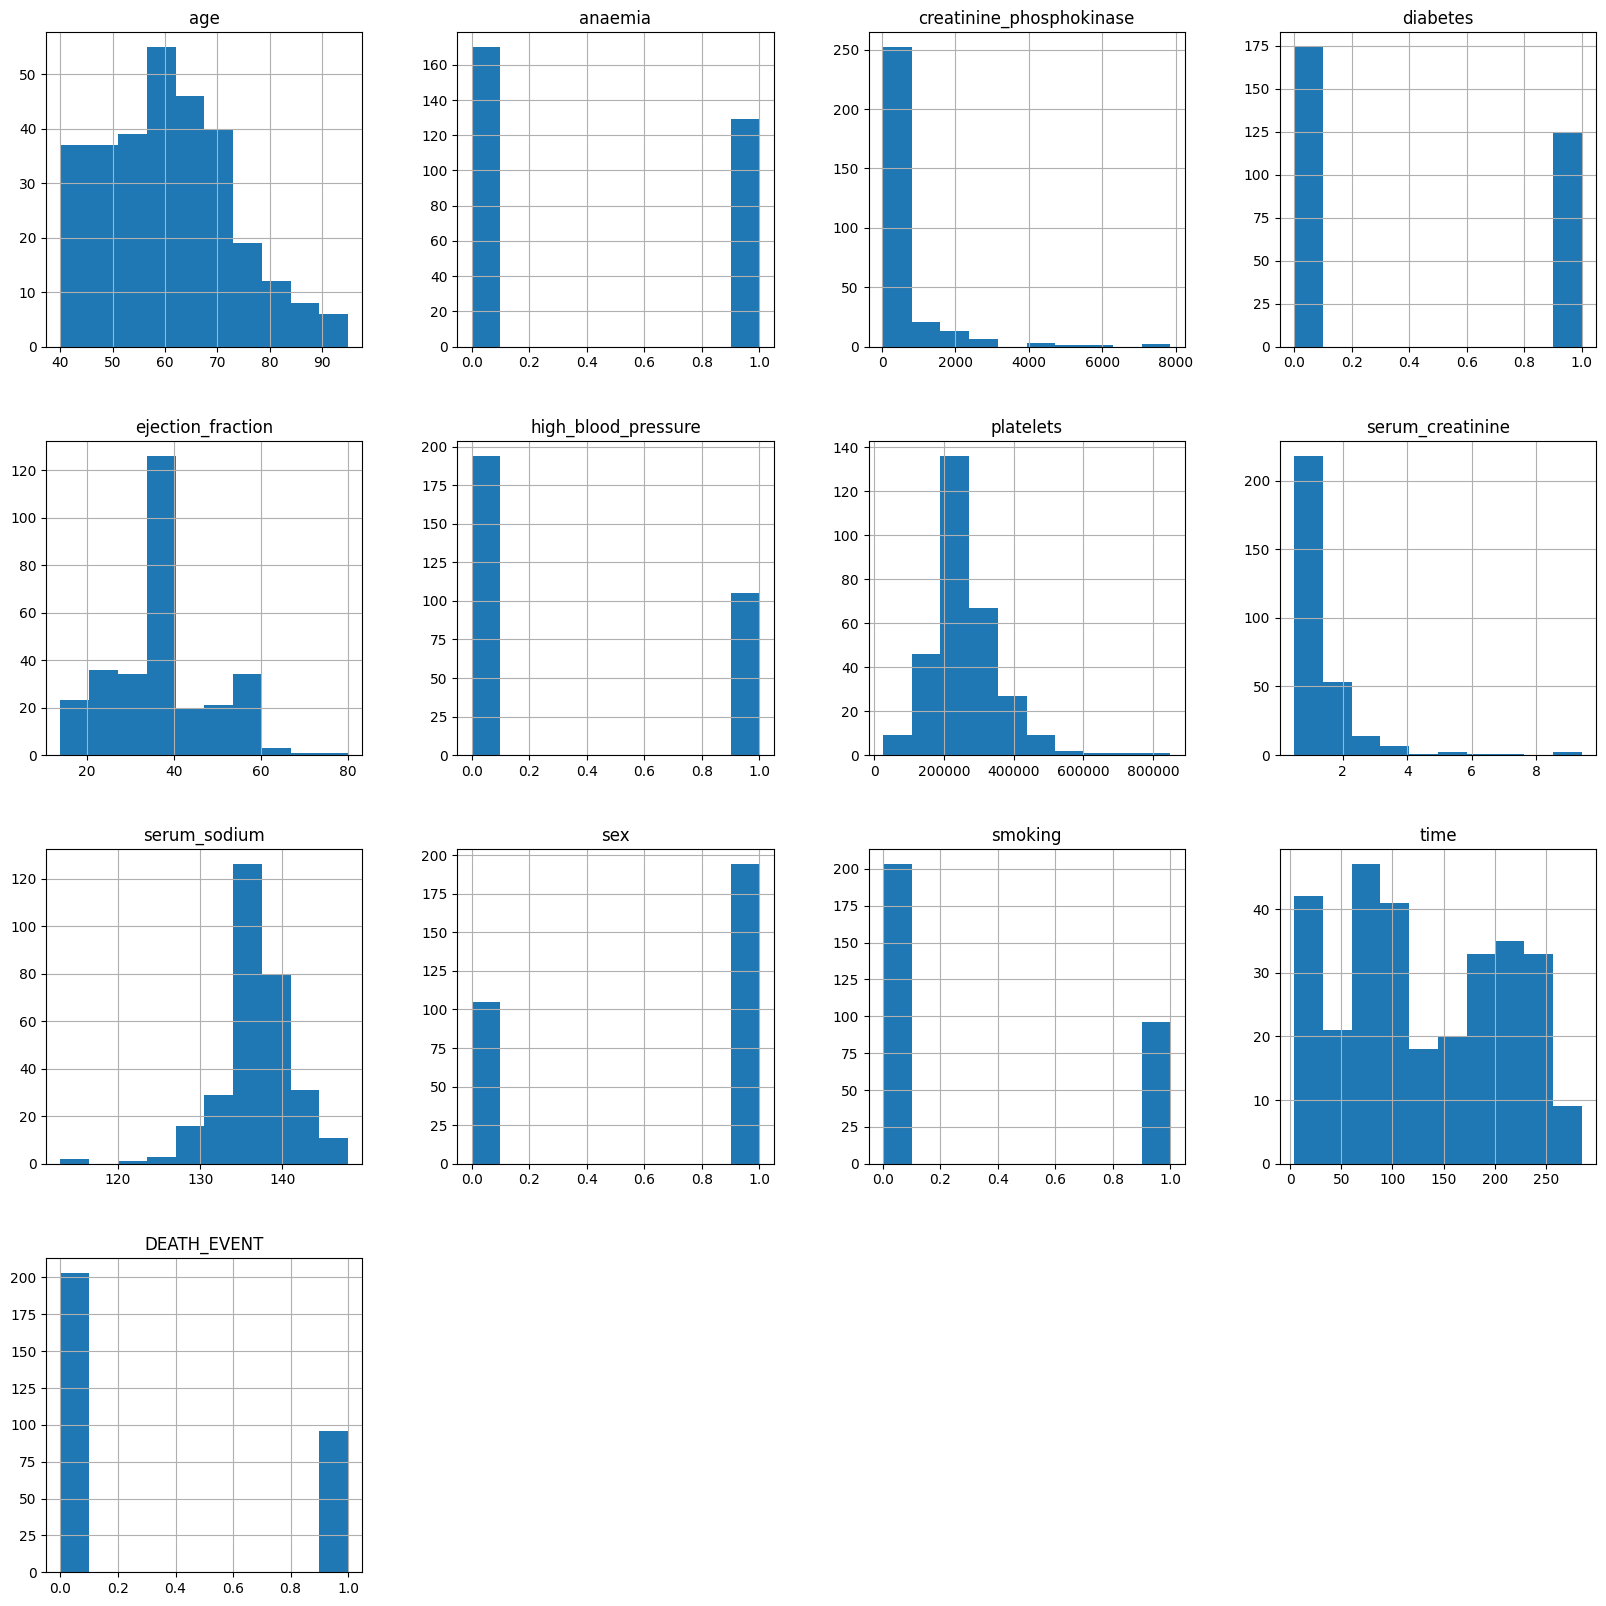

In [144]:
# Show the distribution of all the columns (both features and targets). We do this 
# to explore our data so that we better know how to proceed with the training. 
# This should be improved.

dataset.hist(figsize=(20,20))

We did this analysis to determine which version of naive bayes to use. We can see that some of the features are what we can consider normally distributed and some are binary. The normally distributed features aren't necessarily bell shaped like we would expect for normally distributed data, but they are closer to normally distributed than the alternative (binary/frequency).

The fact that we have two different types of distributions in our features means that we might have to create a custom classifier that combines a gaussian and bernoulli classifier to achieve optimal performance.

## Training & Tuning

In [145]:
# Split into 80/20. 80% for cross validated training, and 20% for final testing

trainval = dataset.groupby('DEATH_EVENT', group_keys=False)[dataset.columns].apply(lambda x: x.sample(frac=0.8))
test = dataset.drop(trainval.index)

In [146]:
# Separate input features from targets in all partitions

features = dataset.drop('DEATH_EVENT', axis=1)
targets = dataset['DEATH_EVENT']
trainval_features = trainval.drop('DEATH_EVENT', axis=1)
trainval_targets = trainval['DEATH_EVENT']
test_features = test.drop('DEATH_EVENT', axis=1)
test_targets = test['DEATH_EVENT']


In [147]:
# A custom function for evaluation the performance using accuracy, precision, recall, f1 and roc_auc.
# Works well for when your data partitions are fixed.
def evaluate(model):

    # Store the prediction probabilites and the predictions. We need the probabilities for 
    # roc_auc_score metric

    train_probabilities = model.predict_proba(trainval_features)
    # train_predictions = model.predict(train_features)
    # This does the same as the statement above without having the model predict again
    train_predictions = model.classes_.take(np.argmax(train_probabilities, axis=1), axis=0)

    # Print the training and validation scores

    print(f'Training Accuracy: {accuracy_score(trainval_targets, train_predictions)}')
    print(f'Training Precision: {precision_score(trainval_targets, train_predictions)}')
    print(f'Training Recall: {recall_score(trainval_targets, train_predictions)}')
    print(f'Training F1: {f1_score(trainval_targets, train_predictions)}')
    print(f'Training ROC AUC: {roc_auc_score(trainval_targets, train_probabilities[:,1])}')
    
    # Evaluate and print the final test scores     

    test_probabilities = model.predict_proba(test_features)
    test_predictions = model.classes_.take(np.argmax(test_probabilities, axis=1), axis=0)

    print(f'Test Accuracy: {accuracy_score(test_targets, test_predictions)}')
    print(f'Test Precision: {precision_score(test_targets, test_predictions)}')
    print(f'Test Recall: {recall_score(test_targets, test_predictions)}')
    print(f'Test F1: {f1_score(test_targets, test_predictions)}')
    print(f'Test ROC AUC: {roc_auc_score(test_targets, test_probabilities[:,1])}')
    print()

In [148]:
# A function for running tests on specified data
def evaluate2(estimator, X, y):
    # Get the prediction probabilities for each class
    probabilities = estimator.predict_proba(X)
    # Get the indices of the highest probabilities for each prediction
    prediction_indices = np.argmax(probabilities, axis=1)
    # Build a list with the appropriate class labels for each prediction
    predictions = estimator.classes_.take(prediction_indices, axis=0)

    return {
        'accuracy': accuracy_score(y, predictions), 
        'precision': precision_score(y, predictions), 
        'recall': recall_score(y, predictions), 
        'f1': f1_score(y, predictions), 
        'roc_auc': roc_auc_score(y, probabilities[:,1]), 
        }

In [149]:
# A custom function for returning the results for all metrics based on the best f1 score on test data
def show_cv_results(cv_results):
    # Sort the values in the frame according to their rank in f1
    sorted_results = cv_results.sort_values('rank_test_f1',ascending=True)
    # return the relevant scores for the first row of the data
    return sorted_results[['mean_train_f1', 'mean_train_precision', 'mean_train_recall', 'mean_train_accuracy', 'mean_train_roc_auc', 'mean_test_f1', 'mean_test_precision', 'mean_test_recall', 'mean_test_accuracy', 'mean_test_roc_auc']].iloc[0]

In [150]:
# Define the metrics that we wan't to use. The names of available scorers can be accessed through
# get_scorer_names. The actual scorer objects are found using get_scorer. This is done internally in all sklearn 
# functions that accept metric names
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

In [151]:
# Train a decision tree using grid search and nested cross validation. A nested CV setup is 
# the best way of training, hyperparameter tuning, and a final evaluation on unseen test data.

dt_params = {
    'criterion': ['gini', 'entropy'], 
    'max_depth': range(1,21)
    # Needs to be expanded with more parameters
}

# Define our stratified kfold iterators, one for the outer iterations through the external test folds
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
# and one to be used by GridSearchCV in the inner iterations through the validation folds that is used to
# validate the performance hyperparameter values. The training data will consist of the remaining three 
# folds in each iteration. 
# Note that we pass in the same random seed to each iterator. We can now fix the random seed as we 
# are using the entire dataset for final testing irregardles of seed. 
inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=13)

# Create lists for storing our results
dt_cv_results = []
dt_estimators = []
dt_test_scores = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'roc_auc': [],
}

# The iterators are used to split the data into training and test data
for (train_index, test_index) in list(outer_cv.split(features, targets)):

    # Employ grid search to find the hyperparameter values in the specified grid. We pass in the 
    # inner cv iterator
    dt_grid = GridSearchCV(DecisionTreeClassifier(), dt_params, cv=inner_cv, scoring=metrics, refit='f1',return_train_score=True)

    # Perform cross validated training and tuning on the current training and validation data
    dt_grid.fit(features.iloc[train_index], targets.iloc[train_index])

    # Store the cv results for current iteration
    cv_results = pd.DataFrame(dt_grid.cv_results_)
    dt_cv_results.append(cv_results)

    # Store the best estimator for the current iteration
    dt_estimators.append(dt_grid.best_estimator_)

    # Evaluate and store the scores of the best estimator on the current test fold
    evaluation = evaluate2(dt_grid, features.iloc[test_index], targets.iloc[test_index])
    dt_test_scores['accuracy'].append(evaluation['accuracy'])
    dt_test_scores['precision'].append(evaluation['precision'])
    dt_test_scores['recall'].append(evaluation['recall'])
    dt_test_scores['f1'].append(evaluation['f1'])
    dt_test_scores['roc_auc'].append(evaluation['roc_auc'])
    

In [152]:
# Convert the scores into a dataframe
dt_test_scores = pd.DataFrame(dt_test_scores)
# Show the mean scores across all test folds
dt_test_scores.mean()

accuracy     0.782203
precision    0.684345
recall       0.614211
f1           0.645422
roc_auc      0.765815
dtype: float64

In [153]:
# Concat the cv_result frames together
cv_results_frame = pd.concat(dt_cv_results, names=['test_split'], keys=range(5), axis=0)
# Find the best scores for each split according to the maximum f1 scores
cv_scores = cv_results_frame.groupby('test_split').apply(lambda frame: frame.sort_values('rank_test_f1')[['mean_test_accuracy', 'mean_test_precision', 'mean_test_recall', 'mean_test_f1', 'mean_test_roc_auc']].iloc[0])
# Show the cross validation results (no training results selected)
cv_scores


,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_roc_auc
test_split,,,,,
0,0.853531,0.855611,0.657895,0.740659,0.801280
1,0.849011,0.886905,0.649342,0.739773,0.796622
2,0.819703,0.731746,0.752632,0.732362,0.818270
3,0.828107,0.735819,0.753289,0.740715,0.862612
4,0.850000,0.772123,0.766447,0.767949,0.828041


In [154]:
# Print the best estimators to verify that we have trained a different classifier for each 
# split (under the assumption that the best parameter values will be different between the iterations)
print(dt_estimators)

[DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(criterion='entropy', max_depth=3), DecisionTreeClassifier(criterion='entropy', max_depth=3), DecisionTreeClassifier(max_depth=17)]


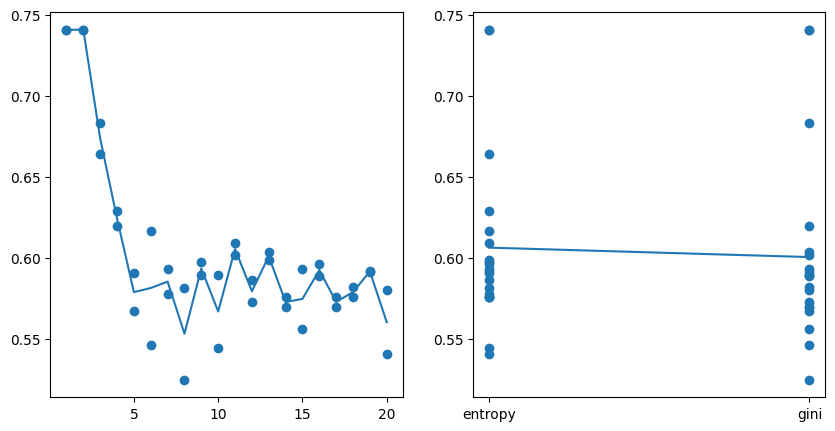

In [155]:
# Investigate the performance of the different parameter values using pyplot
# This works for a single cv_result only, and the setup would have to be modified for 
# accounting for nested cross validation. I've added an index ([0]) to keep the code working

# Create a new frame with the relevant columns. We have tuned two parameters so far, and we want to find the best 
# values according to the f1 test (validation) results
dt_param_scores = dt_cv_results[0][['param_max_depth', 'param_criterion', 'mean_test_f1']]

# Create a new frame where we have organized the values that we can find the average max_depth performance 
# accross the other parameter values
dt_max_depth = dt_param_scores.pivot_table(index='param_criterion', columns='param_max_depth', values='mean_test_f1')
dt_max_depth_means = dt_max_depth.mean(axis=0)

# A frame to find the average performance of each criteria value
dt_criterion = dt_param_scores.pivot_table(index='param_max_depth', columns='param_criterion', values='mean_test_f1')
dt_criterion_means = dt_criterion.mean(axis=0)

# Plot everything, one plot for each parameter tuned
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(dt_max_depth_means.index, dt_max_depth_means)
ax[0].scatter(dt_cv_results[0]['param_max_depth'], dt_cv_results[0]['mean_test_f1'])
ax[1].plot(dt_criterion_means.index, dt_criterion_means)
ax[1].scatter(dt_cv_results[0]['param_criterion'], dt_cv_results[0]['mean_test_f1'])
plt.show()


<Axes: xlabel='param_max_depth', ylabel='mean_test_f1'>

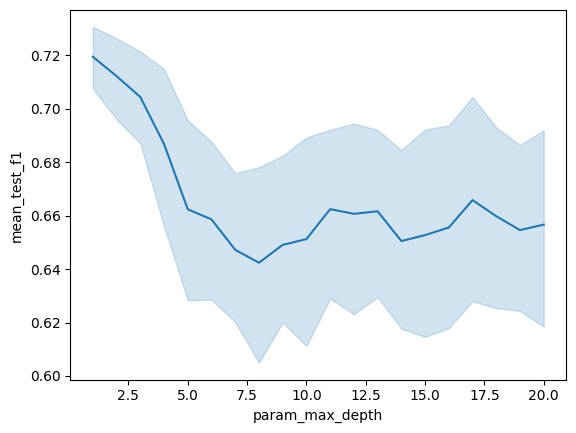

In [156]:
# Evaluate the performance of a parameter value accross all test splits (and other parameter values)
# We reset the index to be able to set a new index. This will make the test_split index become a 
# column
cv_results_frame.reset_index(inplace=True)
# Fetch all relevant columns
param_scores = cv_results_frame[['test_split', 'param_max_depth', 'param_criterion', 'mean_test_f1']]
# Set the desired index. In this case we set every thin except the score. This makes us able to access 
# values in groups according to what indices we specify
param_scores = param_scores.set_index(['test_split', 'param_max_depth', 'param_criterion'])

# Plot the scores for param_max_depth
sb.lineplot(data=param_scores, x='param_max_depth', y='mean_test_f1')


In [157]:
# This function only works for a single cv_results (not nested CV)
show_cv_results(dt_cv_results[0])

mean_train_f1           0.740741
mean_train_precision    0.848357
mean_train_recall       0.657895
mean_train_accuracy     0.853554
mean_train_roc_auc      0.801333
mean_test_f1            0.740659
mean_test_precision     0.855611
mean_test_recall        0.657895
mean_test_accuracy      0.853531
mean_test_roc_auc       0.801280
Name: 0, dtype: float64

In [158]:
# This function only works for a single cv_results (not nested CV)
evaluate(dt_estimators[0])

Training Accuracy: 0.8410041841004184
Training Precision: 0.819672131147541
Training Recall: 0.6493506493506493
Training F1: 0.7246376811594203
Training ROC AUC: 0.790724707391374
Test Accuracy: 0.8666666666666667
Test Precision: 0.8666666666666667
Test Recall: 0.6842105263157895
Test F1: 0.7647058823529413
Test ROC AUC: 0.8177150192554556



In [159]:
# Calculate the confusion matrix for the best decision tree model. This works because 
# dt_grid is still available from the last iteration through the outer CV loop

confusion_matrix(test_targets, dt_grid.predict(test_features))

array([[40,  1],
       [ 2, 17]])

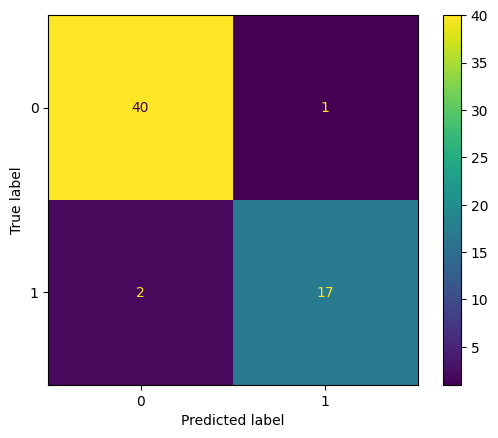

In [160]:
# The ConfusionMatrixDisplay class can be used to make confusion matrix plots. This works because 
# dt_grid is still available from the last iteration through the outer CV loop

ConfusionMatrixDisplay.from_estimator(dt_grid, test_features, test_targets)

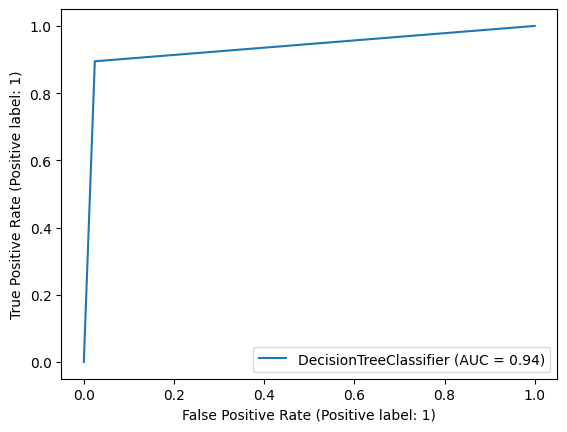

In [161]:
# Plot the ROC curve for the best decision tree model

# These two statements achieves the same thing
# RocCurveDisplay.from_predictions(test_targets, dt2.predict_proba(test_features)[:,1])
RocCurveDisplay.from_estimator(dt_grid.best_estimator_, test_features, test_targets)

In [162]:
# Train and evaluate a gaussian naive bayesian classifier with default parameters

nb_params = {
    'var_smoothing': np.logspace(-10, -5, 6) # The values are specified with the exponents i.e. 1e-10, ..., 1e-5
}
nb_grid = GridSearchCV(GaussianNB(), nb_params, scoring=metrics, refit='f1', return_train_score=True)
nb_grid.fit(trainval_features, trainval_targets)
nb_cv_results = pd.DataFrame(nb_grid.cv_results_)
nb_cv_results

/home/lars/.venv/sklearn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lars/.venv/sklearn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_var_smoothing,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_train_accuracy,split1_train_accuracy,split2_train_accuracy,split3_train_accuracy,split4_train_accuracy,mean_train_accuracy,std_train_accuracy,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,split4_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_train_precision,split1_train_precision,split2_train_precision,split3_train_precision,split4_train_precision,mean_train_precision,std_train_precision,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_train_recall,split1_train_recall,split2_train_recall,split3_train_recall,split4_train_recall,mean_train_recall,std_train_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_train_f1,split1_train_f1,split2_train_f1,split3_train_f1,split4_train_f1,mean_train_f1,std_train_f1,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,split0_train_roc_auc,split1_train_roc_auc,split2_train_roc_auc,split3_train_roc_auc,split4_train_roc_auc,mean_train_roc_auc,std_train_roc_auc
0,0.001372,0.000127,0.006625,0.002772,0.0,{'var_smoothing': 1e-10},0.812500,0.854167,0.854167,0.791667,0.787234,0.819947,0.029214,2,0.811518,0.774869,0.764398,0.801047,0.791667,0.788700,0.017110,0.800000,0.833333,0.909091,0.875000,0.666667,0.816818,0.083667,1,0.795455,0.731707,0.722222,0.734694,0.775000,0.751816,0.028338,0.533333,0.666667,0.6250,0.4375,0.666667,0.585833,0.088726,2,0.564516,0.483871,0.426230,0.590164,0.500000,0.512956,0.058574,0.640000,0.740741,0.740741,0.583333,0.666667,0.674296,0.060561,2,0.660377,0.582524,0.536082,0.654545,0.607843,0.608275,0.046326,0.866667,0.892929,0.929688,0.769531,0.822917,0.856346,0.055638,1,0.881720,0.872843,0.853972,0.894199,0.888834,0.878314,0.014121
1,0.001224,0.000033,0.005054,0.000148,0.0,{'var_smoothing': 1e-09},0.770833,0.875000,0.833333,0.833333,0.787234,0.819947,0.037072,1,0.811518,0.790576,0.801047,0.821990,0.812500,0.807526,0.010762,0.700000,0.846154,0.785714,0.900000,0.692308,0.784835,0.080972,3,0.795455,0.750000,0.794872,0.754717,0.770833,0.773175,0.019237,0.466667,0.733333,0.6875,0.5625,0.600000,0.610000,0.093934,1,0.564516,0.532258,0.508197,0.655738,0.596774,0.571497,0.051635,0.560000,0.785714,0.733333,0.692308,0.642857,0.682842,0.077344,1,0.660377,0.622642,0.620000,0.701754,0.672727,0.655500,0.030984,0.812121,0.886869,0.914062,0.779297,0.827083,0.843887,0.049468,2,0.879845,0.861340,0.847541,0.881841,0.879777,0.870069,0.013506
2,0.001194,0.000055,0.005333,0.000123,0.0,{'var_smoothing': 1e-08},0.750000,0.875000,0.833333,0.833333,0.787234,0.815780,0.043047,3,0.832461,0.811518,0.806283,0.821990,0.833333,0.821117,0.010871,0.666667,0.800000,0.833333,0.900000,0.727273,0.785455,0.081388,2,0.826087,0.809524,0.785714,0.745455,0.812500,0.795856,0.028358,0.400000,0.800000,0.6250,0.5625,0.533333,0.584167,0.130554,3,0.612903,0.548387,0.540984,0.672131,0.629032,0.600687,0.049713,0.500000,0.800000,0.714286,0.692308,0.615385,0.664396,0.101079,3,0.703704,0.653846,0.640777,0.706897,0.709091,0.682863,0.029370,0.777778,0.882828,0.890625,0.789062,0.835417,0.835142,0.046403,3,0.869592,0.844961,0.834174,0.862043,0.862779,0.854710,0.013093
3,0.001236,0.000067,0.005214,0.000095,0.0,{'var_smoothing': 1e-07},0.729167,0.854167,0.833333,0.770833,0.829787,0.803457,0.046348,4,0.811518,0.790576,0.780105,0.821990,0.807292,0.802296,0.015018,0.625000,0.833333,0.833333,0.692308,0.818182,0.760431,0.085962,4,0.809524,0.805556,0.771429,0.775510,0.790698,0.790543,0.015343,0.333333,0.666667,0.6250,0.5625,0.600000,0.557500,0.

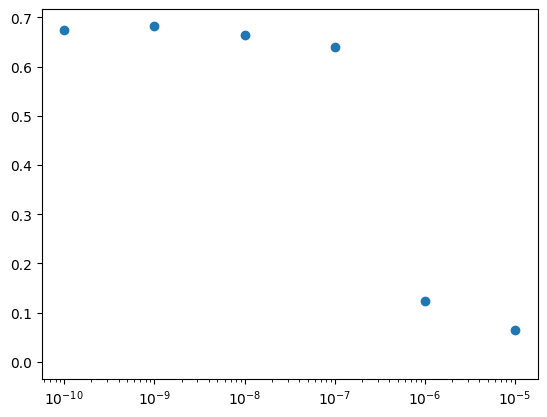

In [163]:
fig, ax = plt.subplots(1,1)
ax.semilogx(1e-10, 0)
plt.scatter(nb_cv_results['param_var_smoothing'], nb_cv_results['mean_test_f1'])

In [164]:
show_cv_results(nb_cv_results)

mean_train_f1           0.655500
mean_train_precision    0.773175
mean_train_recall       0.571497
mean_train_accuracy     0.807526
mean_train_roc_auc      0.870069
mean_test_f1            0.682842
mean_test_precision     0.784835
mean_test_recall        0.610000
mean_test_accuracy      0.819947
mean_test_roc_auc       0.843887
Name: 1, dtype: float64

* The two models performs exactly the same on test data, which makes us have to fall back to validation data in determining which models is the best
* nb1 is the better of the two for validation data. (Individual metrics should be discussed)

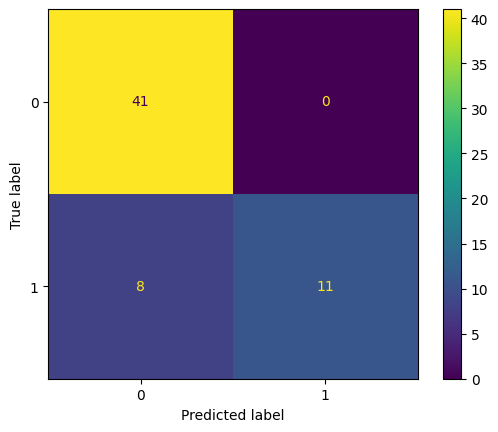

In [165]:
# Plot the confusion matrix for the best NB

ConfusionMatrixDisplay.from_estimator(nb_grid, test_features, test_targets)

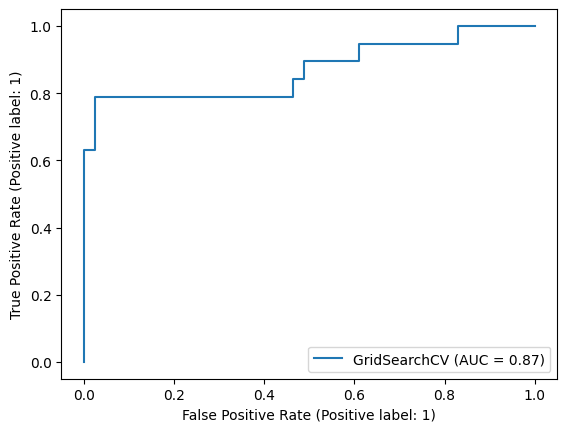

In [166]:
RocCurveDisplay.from_estimator(nb_grid, test_features, test_targets)

In [167]:
class CombinedNB(ClassifierMixin, BaseEstimator):

    def __init__(self, gaussian=GaussianNB(), gaussian_features=None, bernoulli=BernoulliNB(), bernoulli_features=None):
        
        self.gaussian_features = gaussian_features
        self.bernoulli_features  = bernoulli_features
        
        self.gaussian = gaussian 
        self.bernoulli = bernoulli 

    def fit(self, X, y):
        self.gaussian.fit(X[self.gaussian_features], y)
        self.bernoulli.fit(X[self.bernoulli_features], y)
        self.classes_ = self.gaussian.classes_
       

    def predict(self, X):
        predict_proba = self.predict_proba(X)
            
        return np.argmax(predict_proba, axis=1)

    def predict_proba(self, X):
        gaussian_proba = self.gaussian.predict_proba(X[self.gaussian_features])
        bernoulli_proba = self.bernoulli.predict_proba(X[self.bernoulli_features])
        proba = gaussian_proba * bernoulli_proba
        return proba


In [168]:
combined_params = {
    'gaussian__var_smoothing':np.logspace(-10, -5, 6),
    'bernoulli__alpha': np.logspace(-4, 0, 5)
}
gaussian_features = [
    'age', 
    'creatinine_phosphokinase', 
    'ejection_fraction', 
    'platelets',  
    'serum_creatinine', 
    'serum_sodium', 
    'time' ]
bernoulli_features = list(filter(lambda x: x not in gaussian_features, trainval_features.columns))
grid_combined = GridSearchCV(
    CombinedNB(gaussian_features=gaussian_features, bernoulli_features=bernoulli_features), 
    combined_params, 
    scoring=metrics,
    refit='f1', 
    return_train_score=True)
# combined = CombinedNB(gaussian_features=gaussian_features, bernoulli_features=bernoulli_features)
# combined.fit(trainval_features, trainval_targets)
grid_combined.fit(trainval_features, trainval_targets)
combined_cv_results = pd.DataFrame(grid_combined.cv_results_)

/home/lars/.venv/sklearn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lars/.venv/sklearn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lars/.venv/sklearn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lars/.venv/sklearn/lib/python3.11/site-packages/sklearn/metrics/_classification

In [169]:
show_cv_results(combined_cv_results)

mean_train_f1           0.538162
mean_train_precision    0.831304
mean_train_recall       0.399260
mean_train_accuracy     0.780339
mean_train_roc_auc      0.868334
mean_test_f1            0.500114
mean_test_precision     0.780556
mean_test_recall        0.375000
mean_test_accuracy      0.765514
mean_test_roc_auc       0.828673
Name: 1, dtype: float64

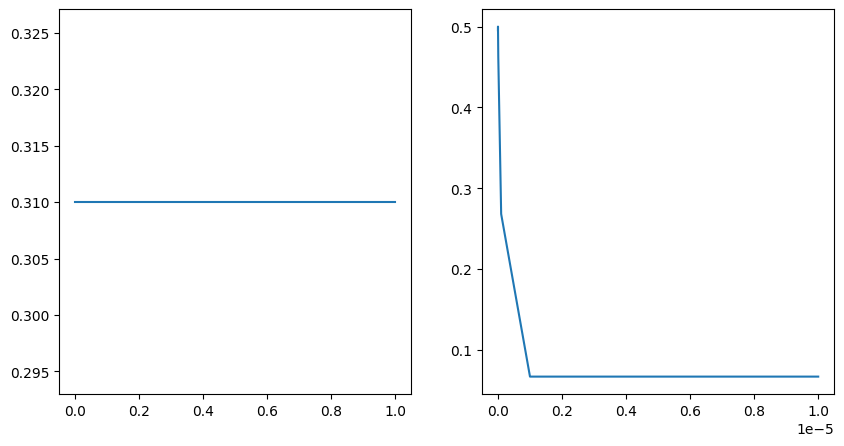

In [170]:
# Create a new frame with the relevant columns. We have tuned two parameters so far, and we want to find the best 
# values according to the f1 test (validation) results
combined_param_scores = combined_cv_results[['param_gaussian__var_smoothing', 'param_bernoulli__alpha', 'mean_test_f1']]

# Create a new frame where we have organized the values that we can find the average max_depth performance 
# accross the other parameter values
combined_var_smoothing = combined_param_scores.pivot_table(index='param_bernoulli__alpha', columns='param_gaussian__var_smoothing', values='mean_test_f1')
combined_var_smoothing_means = combined_var_smoothing.mean(axis=0)

# A frame to find the average performance of each criteria value
combined_alpha = combined_param_scores.pivot_table(index='param_gaussian__var_smoothing', columns='param_bernoulli__alpha', values='mean_test_f1')
combined_alpha_means = combined_alpha.mean(axis=0)

# Plot everything, one plot for each parameter tuned
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(combined_alpha_means.index, combined_alpha_means)
ax[1].plot(combined_var_smoothing_means.index, combined_var_smoothing_means)
plt.show()

In [171]:
svc_params = {
    'C': [0.5, 1.0, 2.0, 4.0], 
    'kernel': ['rbf', 'poly', 'sigmoid'],
    'class_weight': ['balanced', None]
}
svc_grid = GridSearchCV(SVC(probability=True), svc_params, scoring=metrics, refit='f1', return_train_score=True)
svc_grid.fit(trainval_features, trainval_targets)
svc_cv_results = pd.DataFrame(svc_grid.cv_results_)
svc_cv_results

/home/lars/.venv/sklearn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lars/.venv/sklearn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lars/.venv/sklearn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lars/.venv/sklearn/lib/python3.11/site-packages/sklearn/metrics/_classification

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_kernel,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_train_accuracy,split1_train_accuracy,split2_train_accuracy,split3_train_accuracy,split4_train_accuracy,mean_train_accuracy,std_train_accuracy,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,split4_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_train_precision,split1_train_precision,split2_train_precision,split3_train_precision,split4_train_precision,mean_train_precision,std_train_precision,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_train_recall,split1_train_recall,split2_train_recall,split3_train_recall,split4_train_recall,mean_train_recall,std_train_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_train_f1,split1_train_f1,split2_train_f1,split3_train_f1,split4_train_f1,mean_train_f1,std_train_f1,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,split0_train_roc_auc,split1_train_roc_auc,split2_train_roc_auc,split3_train_roc_auc,split4_train_roc_auc,mean_train_roc_auc,std_train_roc_auc
0,0.005532,0.000330,0.005912,0.000240,0.5,balanced,rbf,"{'C': 0.5, 'class_weight': 'balanced', 'kernel...",0.604167,0.687500,0.500000,0.583333,0.617021,0.598404,0.060379,14,0.628272,0.612565,0.596859,0.638743,0.588542,0.612996,0.018735,0.333333,0.500000,0.318182,0.333333,0.421053,0.381180,0.069650,4,0.390244,0.333333,0.391892,0.416667,0.383562,0.383139,0.027320,0.266667,0.200000,0.4375,0.2500,0.533333,0.337500,0.126436,10,0.258065,0.193548,0.475410,0.327869,0.451613,0.341301,0.108714,0.296296,0.285714,0.368421,0.285714,0.470588,0.341347,0.071632,10,0.310680,0.244898,0.429630,0.366972,0.414815,0.353399,0.068359,0.559596,0.703030,0.507812,0.501953,0.525000,0.559478,0.074531,10,0.569892,0.534259,0.572636,0.582976,0.572829,0.566518,0.016734
1,0.005985,0.002201,0.005558,0.000160,0.5,balanced,poly,"{'C': 0.5, 'class_weight': 'balanced', 'kernel...",0.312500,0.312500,0.333333,0.354167,0.382979,0.339096,0.026836,21,0.329843,0.329843,0.324607,0.345550,0.322917,0.330552,0.007995,0.312500,0.312500,0.333333,0.333333,0.325000,0.323333,0.009354,9,0.324468,0.324468,0.319149,0.320225,0.319149,0.321492,0.002462,1.000000,1.000000,1.0000,0.9375,0.866667,0.960833,0.052941,1,0.983871,0.983871,0.983607,0.934426,0.967742,0.970703,0.019173,0.476190,0.476190,0.500000,0.491803,0.472727,0.483382,0.010621,1,0.488000,0.488000,0.481928,0.476987,0.480000,0.482983,0.004389,0.575758,0.676768,0.507812,0.488281,0.560417,0.561807,0.065930,5,0.559765,0.532008,0.568979,0.582850,0.563772,0.561475,0.016671
2,0.006847,0.000076,0.005858,0.000256,0.5,balanced,sigmoid,"{'C': 0.5, 'class_weight': 'balanced', 'kernel...",0.687500,0.687500,0.666667,0.645833,0.659574,0.669415,0.016215,12,0.670157,0.670157,0.670157,0.685864,0.671875,0.673642,0.006147,0.500000,0.500000,0.000000,0.333333,0.000000,0.266667,0.226078,13,0.444444,0.444444,0.000000,0.600000,0.000000,0.297778,0.249681,0.066667,0.066667,0.0000,0.0625,0.000000,0.039167,0.032016,14,0.064516,0.064516,0.000000,0.049180,0.000000,0.035643,0.029636,0.117647,0.117647,0.000000,0.105263,0.000000,0.068111,0.055796,14,0.112676,0.112676,0.000000,0.090909,0.000000,0.063252,0.052253,0.559596,0.723232,0.603516,0.478516,0.575000,0.587972,0.079361,3,0.581395,0.537884,0.504161,0.570492,0.500744,0.538935,0.033068
3,0.004291,0.000277,0.005556,0.000108,0.5,None,rbf,"{'C': 0.5, 'class_weight': None, 'kernel': 'rbf'}",0.687500,0.687500,0.666667,0.666667,0.680851,0.677837,0.009438,1,0.675393,0.675393,0.680628,0.680628,0.677083,0.677825

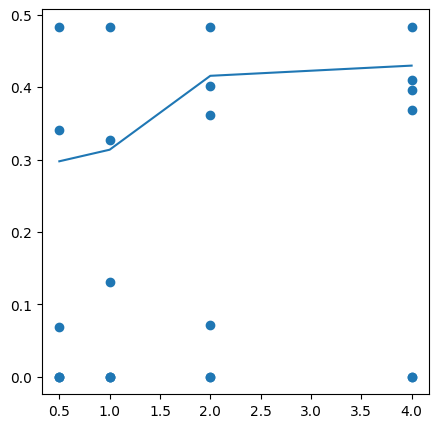

In [172]:
# Investigate the performance of the different parameter values

# Create a new frame with the relevant columns. We have tuned three parameters so far, and we want to find the best 
# values according to the f1 test (validation) results
svc_param_scores = svc_cv_results[['param_C', 'param_class_weight', 'param_kernel', 'mean_test_f1']]

# Create a new frame where we have organized the values that we can find the average C performance 
# accross the other parameter values
svc_c = svc_param_scores.pivot_table(index=['param_class_weight','param_kernel'], columns='param_C', values='mean_test_f1')
svc_c_means = svc_c.mean(axis=0)

# Plot everything, one plot for each parameter tuned
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.plot(svc_c_means.index, svc_c_means)
ax.scatter(svc_cv_results['param_C'], svc_cv_results['mean_test_f1'])
plt.show()


In [173]:
show_cv_results(svc_cv_results)

mean_train_f1           0.482983
mean_train_precision    0.321492
mean_train_recall       0.970703
mean_train_accuracy     0.330552
mean_train_roc_auc      0.561475
mean_test_f1            0.483382
mean_test_precision     0.323333
mean_test_recall        0.960833
mean_test_accuracy      0.339096
mean_test_roc_auc       0.561807
Name: 1, dtype: float64

In [174]:
# Here you should add a collected presentation of all the results to make it easy to make the final 
# conclusion. I've kept it simple here by only showing the evaluation metrics, but more evaluation 
# methods should be employed

evaluate(dt_grid.best_estimator_)
evaluate(nb_grid.best_estimator_)
evaluate(svc_grid.best_estimator_)

Training Accuracy: 0.9288702928870293
Training Precision: 0.8846153846153846
Training Recall: 0.8961038961038961
Training F1: 0.8903225806451613
Training ROC AUC: 0.9202741702741702
Test Accuracy: 0.95
Test Precision: 0.9444444444444444
Test Recall: 0.8947368421052632
Test F1: 0.918918918918919
Test ROC AUC: 0.9351732991014121

Training Accuracy: 0.8117154811715481
Training Precision: 0.7857142857142857
Training Recall: 0.5714285714285714
Training F1: 0.6616541353383457
Training ROC AUC: 0.8672438672438673
Test Accuracy: 0.8666666666666667
Test Precision: 1.0
Test Recall: 0.5789473684210527
Test F1: 0.7333333333333334
Test ROC AUC: 0.8703465982028241

Training Accuracy: 0.6778242677824268
Training Precision: 0.0
Training Recall: 0.0
Training F1: 0.0
Training ROC AUC: 0.43803110469777135
Test Accuracy: 0.6833333333333333
Test Precision: 0.0
Test Recall: 0.0
Test F1: 0.0
Test ROC AUC: 0.6238767650834403



/home/lars/.venv/sklearn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lars/.venv/sklearn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Based on the metrics shown above we have to conclude that that dt2 is the best classifier for predicting heart failures. Both the confusion matrices and the ROC plots confirm the results. Both classifiers have a significant amount of false negatives, which makes both models complicate to implement in healthcare practice. 

The results are highly dependent on the random sampling in the data partitions. A more thorough analysis is needed to overcome this issue.